In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
print(torch.__version__)
print(torch.backends.mps.is_built())
print(torch.backends.mps.is_available())

is_mps = torch.backends.mps.is_available()
device = torch.device('mps' if is_mps else 'cpu')
print('Current device : ',device)

2.1.0.dev20230426
True
True
Current device :  mps


In [12]:
batch_size = 50
learning_rate = 0.0001
epoch_num = 15

In [13]:
train_data = datasets.MNIST(root = '/Volumes/My Passport/dataset',
                            train=True,
                            download=True,
                            transform = transforms.ToTensor())
test_data = datasets.MNIST(root = '/Volumes/My Passport/dataset',
                           train=False,
                           transform = transforms.ToTensor())

print('number of training data: ',len(train_data))
print('number of test data: ',len(test_data))

0.3%

100.0%


Extracting /Volumes/My Passport/dataset/MNIST/raw/train-images-idx3-ubyte.gz to /Volumes/My Passport/dataset/MNIST/raw



100.0%


Extracting /Volumes/My Passport/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /Volumes/My Passport/dataset/MNIST/raw



100.0%


Extracting /Volumes/My Passport/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /Volumes/My Passport/dataset/MNIST/raw



100.0%

Extracting /Volumes/My Passport/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Volumes/My Passport/dataset/MNIST/raw

number of training data:  60000
number of test data:  10000


torch.Size([1, 28, 28])


Text(0.5, 1.0, 'label:5')

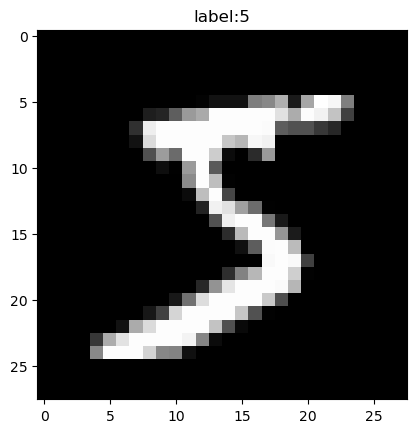

In [14]:
image, label = train_data[0]
#tensorflow 와 다르게 차원 축이 맨 앞에 위치한다. squeeze는 1인 차원을 삭제함
print(image.shape)
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(f'label:{label}')


In [15]:
#미니배치 구성
train_loader = torch.utils.data.DataLoader(dataset = train_data,batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__()


In [16]:
#print 간격 설정
#first_batch의 픽셀값, 라벨값
print('{:15s} | {:<25s} | {}'.format('name','type','size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch','',len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch',str(type(first_batch)),len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]',str(type(first_batch[0])),first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]',str(type(first_batch[1])),first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #Conv2(입력채널의 수(들어오는 데이터 양), 출력채널, 커널 사이즈(3x3), stride(1x1))
        self.conv1 = nn.Conv2d(1,32,3,1,padding='same')
        self.conv2 = nn.Conv2d(32,64,3,1,padding='same')
        self.dropout = nn.Dropout2d(0.25)
        #이미지 해상도 = 28x28, 맥스풀링 2x2로 설정. 풀링 2번 거치며 7x7로 작아짐. 바로 앞 채널과 곱한 크기를 선형계층에 전달
        self.fc1 = nn.Linear(3136,1000)#*7*64
        self.fc2 = nn.Linear(1000,10)#최종 아웃풋 갯수
    
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.dropout(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        #'dim=1'은 log_softmax 함수의 적용 대상인 차원을 지정하는 매개변수. 
        #텐서의 크기가 (batch_size, num_classes)라면, dim=1을 지정하면 두 번째 차원(즉, num_classes에 해당하는 차원)에 대해서 log_softmax 함수를 적용하게 됩
        output = F.log_softmax(x,dim=1) #log_softmax가 속도가 빠름. 
        return output


In [18]:
model = CNN().to(device) #모델을 인스턴시에이션 시킨 후, 디바이스에 올려라.
optimizer = optim.Adam(model.parameters(),lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [19]:
model.train() #훈련할 거라고 선언하는 것.
i=1
for epoch in range(epoch_num): #epoch loop
    for data,target in train_loader: #batch loop
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('Train step : {}\tLoss : {}'.format(i,loss.item()))
        i += 1

Train step : 100	Loss : 0.7151188850402832
Train step : 200	Loss : 0.5080346465110779
Train step : 300	Loss : 0.28048470616340637
Train step : 400	Loss : 0.30649125576019287
Train step : 500	Loss : 0.18425580859184265
Train step : 600	Loss : 0.23009946942329407
Train step : 700	Loss : 0.16801254451274872
Train step : 800	Loss : 0.12933844327926636
Train step : 900	Loss : 0.19969375431537628
Train step : 1000	Loss : 0.0414033941924572
Train step : 1100	Loss : 0.16367992758750916
Train step : 1200	Loss : 0.04470966383814812
Train step : 1300	Loss : 0.050514914095401764
Train step : 1400	Loss : 0.04395879805088043
Train step : 1500	Loss : 0.14772985875606537
Train step : 1600	Loss : 0.18032032251358032
Train step : 1700	Loss : 0.1957457959651947
Train step : 1800	Loss : 0.1216491311788559
Train step : 1900	Loss : 0.1265714317560196
Train step : 2000	Loss : 0.08575296401977539
Train step : 2100	Loss : 0.06768563389778137
Train step : 2200	Loss : 0.1616283357143402
Train step : 2300	Loss : 

In [20]:
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1] #2차원 텐서에서 클래스레이블 형태로 추출 (가장 큰 값의 인덱스)
    correct += prediction.eq(target.data).sum() #예측값과 타겟값이 같은지

print('Test set : Accuracy:{:.2f}%'.format(100. * correct/len(test_loader.dataset)))


Test set : Accuracy:99.17%
